# Current Testing Battery

In [1]:
import sys
import statistics
import numpy
from itertools import product
from timeit import default_timer as timer
from tqdm import tqdm
sys.path.append("..")
import gillespy2
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
from gillespy2.solvers.python import *
#BasicSSASolver
from gillespy2.solvers.numpy import *
#BasicODESolver, BasicRootSolver, BasicTauLeapingSolver, NumPySSASolver, TauLeapingSolver
from gillespy2.solvers.cython import *
#CythonSSASolver
from gillespy2.solvers.cpp import *
#SSACSolver
from gillespy2.solvers.auto import *
#SSASolver
from gillespy2.solvers.stochkit import *
#StochKitODESolver, StochKitSolver

In [3]:
solvers = []
key, value = None, None
for key, value in globals().items():
    if isinstance(value, type) and issubclass(value, gillespy2.GillesPySolver) and value not in solvers:
        solvers.append(value)
print('Imported solvers:')
for i, solver in enumerate(solvers):
    print('{}:\t{}'.format(i+1, solver.name))

Imported solvers:
1:	BasicSSASolver
2:	NumPySSASolver
3:	BasicODESolver
4:	Basic Root Solver
5:	TauLeaping
6:	Basic Tau Leaping Solver
7:	Basic Tau Hybrid Solver
8:	CythonSSASolver
9:	SSACSolver
10:	StochKitSolver
11:	StochKitODESolver


In [4]:
import os
#if 'STOCHKIT_HOME' not in os.environ:
#    os.environ['STOCHKIT_HOME'] = "/mnt/c/Users/seanm/OneDrive/Documents/Research/StochKit"
#print("STOCHKIT_HOME =",os.environ['STOCHKIT_HOME'])

In [5]:
def __get_results(solver, model, number_of_trajectories):
    results = []
    for i in tqdm(range(number_of_trajectories), desc='Model: {0}, Solver: {1}'.format(model.name, solver.name)):
        result = model.run(solver=solver)
        if isinstance(result, dict):
            results.append(result)
        else:
            results.append(result[0])
    return results

In [6]:
def create_distribution(solver, model, number_of_trajectories):
    results = __get_results(solver, model, number_of_trajectories)
    distribution = {}
    for trajectory in results:
        for species in trajectory.keys():
            if species == 'time': continue;
            distribution[species] = []
            for timestep in range(len(trajectory[species])):
                distribution[species].append([])
    trajectory_number = 0
    for trajectory in results:
        for species in trajectory.keys():
            if species == 'time': continue;
            for timestep in range(len(trajectory[species])):
                distribution[species][timestep].append(trajectory[species][timestep])
            
    return distribution    

In [7]:
def get_stats(solver, standard_results, model, number_of_trajectories):
    interior_stats = {}
    test_results = create_distribution(solver, model, number_of_trajectories)          
    for species in test_results:
        interior_stats[species] = []
    for species in test_results:
        for timestep, value in enumerate(test_results[species]):
            interior_stats[species].append(stats.ks_2samp(value, standard_results[species][timestep]))
    return interior_stats

In [10]:
from gillespy2.example_models import Example, MichaelisMenten
standard_results = {}
ks_stats = {}

number_of_trajectories = 50

solver_list = solvers

model_list = [Example(), MichaelisMenten()]

for model in model_list:
    standard_results[model.name] = []
    ks_stats[model.name] = {}
    
for model in model_list:
    standard_results[model.name] = create_distribution(StochKitSolver, model, number_of_trajectories)
    for solver in solver_list:
        if solver in [BasicODESolver, StochKitSolver, StochKitODESolver, TauLeapingSolver]:
            continue
        ks_stats[model.name][solver] = get_stats(solver, standard_results[model.name], model, number_of_trajectories)

Model: Michaelis_Menten, Solver: NumPySSASolver: 100%|██████████| 50/50 [00:04<00:00, 11.87it/s]
Model: Michaelis_Menten, Solver: Basic Root Solver: 100%|██████████| 50/50 [03:11<00:00,  3.84s/it]
Model: Michaelis_Menten, Solver: Basic Tau Leaping Solver: 100%|██████████| 50/50 [00:17<00:00,  2.84it/s]
Model: Michaelis_Menten, Solver: Basic Tau Hybrid Solver: 100%|██████████| 50/50 [00:26<00:00,  1.86it/s]
Model: Michaelis_Menten, Solver: SSACSolver: 100%|██████████| 50/50 [01:53<00:00,  2.28s/it]


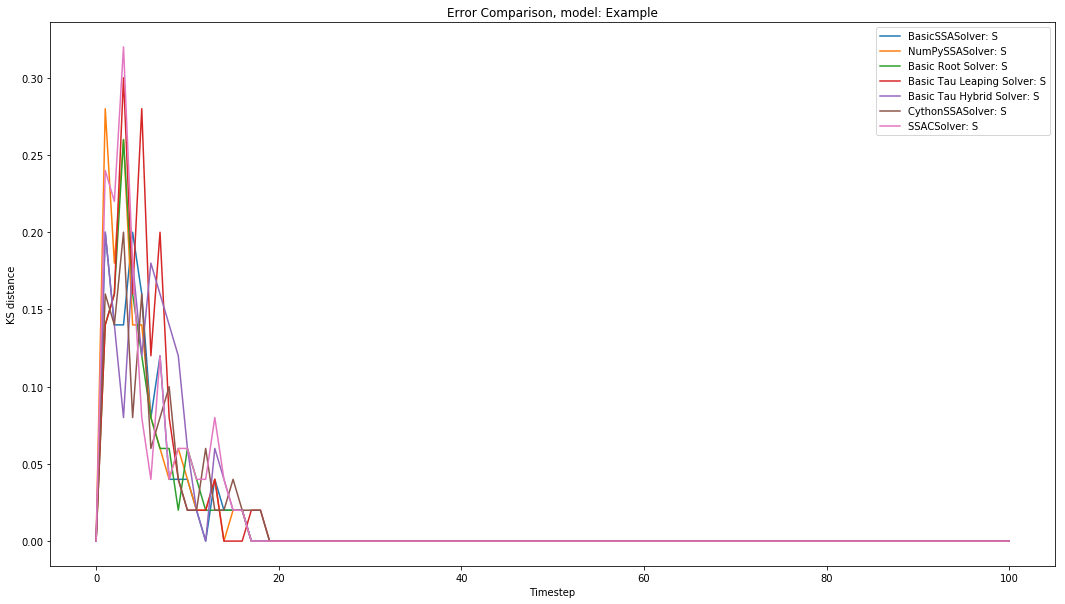

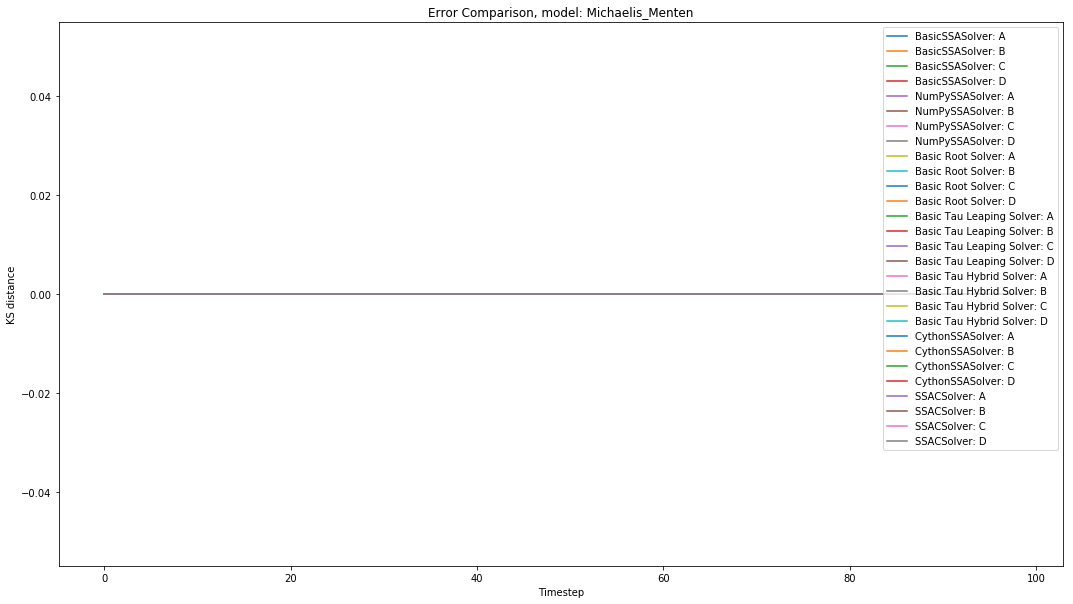

In [11]:
for i in range(len(model_list)):
    model_name = model_list[i].name

    plt.figure(figsize=(18,10))
    for solver in solver_list:
        if solver in ks_stats[model_name]:
            plt.title("Error Comparison, model: " + model_name)
            plt.xlabel("Timestep")
            #plt.ylabel("P-Value")
            plt.ylabel("KS distance")
            for species in ks_stats[model_name][solver]:
                if species is not 'time':            

                    result = ks_stats[model_name][solver][species][:]
                    timesteps = []
                    p_values = []
                    for timestep, value in enumerate(result):
                        timesteps.append(timestep)
                        ks, pv = value
                        p_values.append(ks)
                    plt.plot(timesteps, p_values, label='{0}: {1}'.format(solver.name, species))
    plt.legend(loc='best')
            
#             plt.plot(range(len(ks_stats[model_list[0].name][solver][species])), ks_stats[model_list[0].name][solver][species][:], label=solver.name)
# plt.legend(loc='best')
# for solver in solver_list:
#     print('Using Solver: ', solver.name)
#     for species in ks_stats[model_list[0].name][solver]:
#         if species is not 'time':
#             print('Species: ', species)
#             for timestep, timestep_result in enumerate(ks_stats[model_list[0].name][solver][species]):
#                 print('Timestep ', timestep, ': P-Value: ', timestep_result[1])
#                 plt.plot(timestep, timestep_result[1], label=species)
    

# 1) GET BASIC ODE SOLVER WORKING
# 2) COMPLETE TESTING
# 3)